In [85]:
#!pip install pmdarima
#!pip install skforecast
#!pip install --upgrade statsmodels pmdarima
#!pip install train_feature
!pip install ForecasterAutoreg

ERROR: Could not find a version that satisfies the requirement ForecasterAutoreg (from versions: none)
ERROR: No matching distribution found for ForecasterAutoreg


In [3]:
# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd
import os

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Modelo Auto-Arima
from pmdarima import auto_arima
import pmdarima as pm

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")

In [40]:
# ruta de archivos

#files = os.listdir("c:\\archivos\proyecto")
#os.chdir(r'C:\archivos\proyecto')

csv_path = 'urgencias final_nov.txt'

# Intentar leer el archivo con diferentes codificaciones y manejo de errores
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1']

for encoding in encodings_to_try:
    try:
        df_real = pd.read_csv(csv_path, sep=";", header=None, encoding=encoding)
        # Si se llega a este punto, la lectura fue exitosa, así que puedes salir del bucle
        break
    except UnicodeDecodeError:
        print(f"Error al leer con la codificación {encoding}. Intentando con otra.")

Error al leer con la codificación utf-8. Intentando con otra.


In [41]:
headers = ["FECHA_LLEGADA","TIEMPO_TOTAL_FINAL","CENTRO_ATENCION","CLASIFICACION_TRIAGE","PACIENTE_EDAD","PACIENTE_#_DOCUMENTO","EDAD_RANGO","NOMBRE_ENTIDAD","SEXO","Month"]
print("headers\n", headers)
df_real.columns = headers
df_real = df_real.drop(0)

headers
 ['FECHA_LLEGADA', 'TIEMPO_TOTAL_FINAL', 'CENTRO_ATENCION', 'CLASIFICACION_TRIAGE', 'PACIENTE_EDAD', 'PACIENTE_#_DOCUMENTO', 'EDAD_RANGO', 'NOMBRE_ENTIDAD', 'SEXO', 'Month']


In [42]:
# convertir y arreglar datos
df_real['Month'] = pd.to_datetime(df_real['Month'])

# crear indice de frecuencia
df_real['Month'] = df_real['Month'].dt.to_period('M')
# nuevo_df.index.freq = 'MS'

# indexar
df_real = df_real.set_index("Month")

# numerico
df_real["TIEMPO_TOTAL_FINAL"] = pd.to_numeric(df_real["TIEMPO_TOTAL_FINAL"],errors='coerce')

# Calcular la mediana y arreglar datos

#df["TIEMPO_TOTAL_FINAL"] = pd.to_numeric(df["TIEMPO_TOTAL_FINAL"],errors='coerce')
median = df_real['TIEMPO_TOTAL_FINAL'].median()

# Corregir valores atípicos
df_real.loc[df_real['TIEMPO_TOTAL_FINAL'] > 420, 'TIEMPO_TOTAL_FINAL'] = median
df_real.loc[df_real['TIEMPO_TOTAL_FINAL'] < 0, 'TIEMPO_TOTAL_FINAL'] = median

In [43]:
df_real['FECHA_LLEGADA'] = pd.to_datetime(df_real['FECHA_LLEGADA'])
df_real['DIA_SEMANA'] = df_real['FECHA_LLEGADA'].dt.dayofweek
df_real['ANUAL'] = df_real['FECHA_LLEGADA'].dt.year

In [44]:
# Filtrar a partir del año 2021

anho_inicio = 2022
data1 = df_real[df_real['ANUAL'] >= anho_inicio]
#df_hearth.to_csv('ind_urgencias_final_2023.txt', sep=';', index=False)

In [45]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 224412 entries, 2023-07 to 2023-04
Freq: M
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   FECHA_LLEGADA         224412 non-null  datetime64[ns]
 1   TIEMPO_TOTAL_FINAL    224410 non-null  float64       
 2   CENTRO_ATENCION       224412 non-null  object        
 3   CLASIFICACION_TRIAGE  224412 non-null  object        
 4   PACIENTE_EDAD         224412 non-null  object        
 5   PACIENTE_#_DOCUMENTO  224412 non-null  object        
 6   EDAD_RANGO            224412 non-null  object        
 7   NOMBRE_ENTIDAD        224412 non-null  object        
 8   SEXO                  224412 non-null  object        
 9   DIA_SEMANA            224412 non-null  int64         
 10  ANUAL                 224412 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 20.5+ MB


In [46]:
df = data1

In [47]:
data = data1

In [48]:
data

,FECHA_LLEGADA,TIEMPO_TOTAL_FINAL,CENTRO_ATENCION,CLASIFICACION_TRIAGE,PACIENTE_EDAD,PACIENTE_#_DOCUMENTO,EDAD_RANGO,NOMBRE_ENTIDAD,SEXO,DIA_SEMANA,ANUAL
Month,,,,,,,,,,,
2023-07,2023-07-11 21:19:10,15.00,VC,3,24,1024595942,JUVENTUD,EPSC34,MASCULINO,1,2023
2023-02,2023-02-24 05:31:45,16.00,VB,3,69,4450531,ADULTO MAYOR,EPSC34,MASCULINO,4,2023
2023-08,2023-08-07 23:16:10,16.00,VC,3,50,5267156,ADULTO,EPSC34,FEMENINO,0,2023
2023-09,2023-09-13 01:56:53,17.00,UC,3,79,5667630,ADULTO MAYOR,EPSC34,MASCULINO,2,2023
2023-06,2023-06-29 02:42:38,18.00,UC,3,72,3014617,ADULTO MAYOR,EPSS05,MASCULINO,3,2023
...,...,...,...,...,...,...,...,...,...,...,...
2022-07,2022-07-21 10:27:00,84.33,ME - HOSPITAL MEISSEN,3 - TRIAGE III - NO DEBE SUPERAR LAS 3 HORAS,58 ANO(S),39532594,ADULTEZ,CAPITAL SALUD EPS-S S.A.S,FEMENINO,3,2022
2022-12,2022-12-15 14:50:00,84.33,UC - CENTRO DE SALUD SANTA LIBRADA I,3 - TRIAGE III - NO DEBE SUPERAR LAS 3 HORAS,54 ANO(S),39723106,ADULTEZ,CAPITAL SALUD EPS-S S.A.S,FEMENINO,3,2022
2023-04,2023-04-10 18:02:25,84.33,ME,3,4,1033822858,PRIMERA INFANCIA,EPSC34,MASCULINO,0,2023


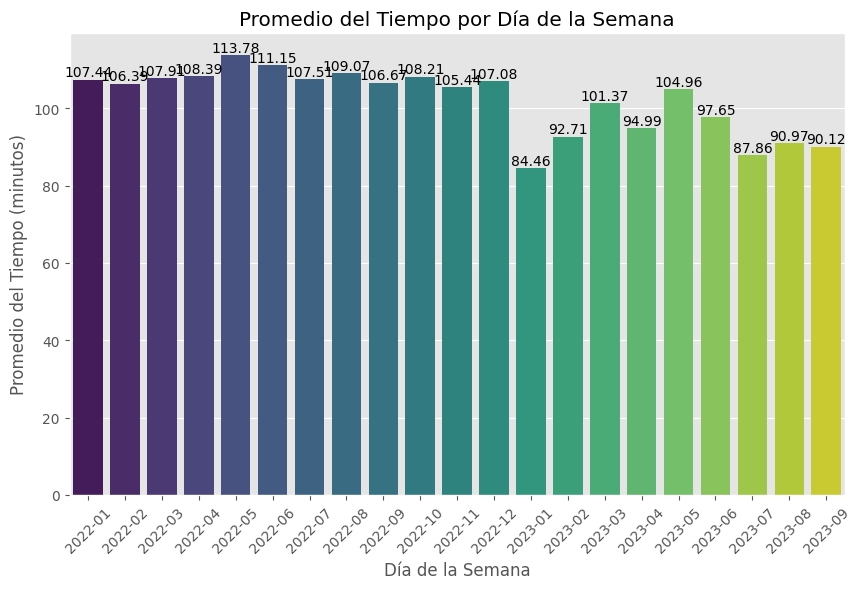

In [51]:
import seaborn as sns

# Agrupar por día de la semana y calcular el promedio del Tiempo_total_minutos en cada grupo

promedio_tiempo_por_grupo =data1.groupby(['Month'])['TIEMPO_TOTAL_FINAL'].mean().reset_index()

# Renombrar la columna del promedio
promedio_tiempo_por_grupo = promedio_tiempo_por_grupo.rename(columns={'TIEMPO_TOTAL_FINAL': 'Promedio_Tiempo'})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=promedio_tiempo_por_grupo, x='Month', y='Promedio_Tiempo', palette='viridis')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio del Tiempo (minutos)')
plt.title('Promedio del Tiempo por Día de la Semana')
plt.xticks(rotation=45)

# Agregar etiquetas en las barras
for index, row in promedio_tiempo_por_grupo.iterrows():
    ax.annotate(str(round(row['Promedio_Tiempo'], 2)), (index, row['Promedio_Tiempo']), ha='center', va='bottom')
plt.show()

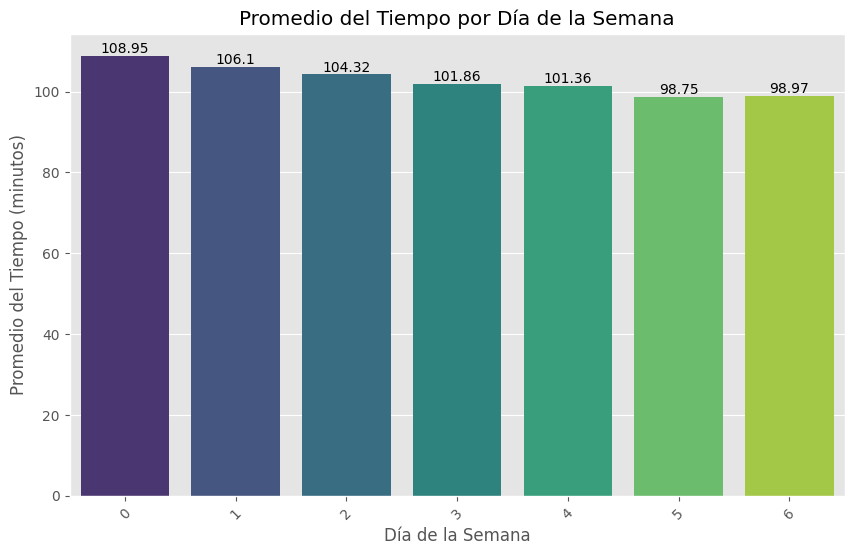

In [52]:
import seaborn as sns

# Agrupar por día de la semana y calcular el promedio del Tiempo_total_minutos en cada grupo

promedio_tiempo_por_grupo =data1.groupby(['DIA_SEMANA'])['TIEMPO_TOTAL_FINAL'].mean().reset_index()

# Renombrar la columna del promedio
promedio_tiempo_por_grupo = promedio_tiempo_por_grupo.rename(columns={'TIEMPO_TOTAL_FINAL': 'Promedio_Tiempo'})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=promedio_tiempo_por_grupo, x='DIA_SEMANA', y='Promedio_Tiempo', palette='viridis')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio del Tiempo (minutos)')
plt.title('Promedio del Tiempo por Día de la Semana')
plt.xticks(rotation=45)

# Agregar etiquetas en las barras
for index, row in promedio_tiempo_por_grupo.iterrows():
    ax.annotate(str(round(row['Promedio_Tiempo'], 2)), (index, row['Promedio_Tiempo']), ha='center', va='bottom')
plt.show()

In [53]:
# Funcion para evaluar

def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [60]:
# Agrupar de acuerdo a la grafica

# agrupamiento de mes
nuevo_df = df.groupby('Month')['TIEMPO_TOTAL_FINAL'].mean().reset_index()

df6 = nuevo_df.copy()

# Convierte el índice Period a cadena
#df6.index = df6.index.astype(str)
df6['Month1'] = df6['Month'].astype(str)

# Crea el gráfico de líneas
fig = px.line(df6, x='Month1', y='TIEMPO_TOTAL_FINAL', template='plotly_dark', title='Total minutos')

# Muestra el gráfico
fig.show()

In [62]:
# División de para entrenamiento y prueba
train_data = df6[:len(df6)-5]
test_data = df6[len(df6)-5:]
test=test_data.copy()

df6=df6.reset_index()

df_fb=df6.rename(columns={"Month":"ds", "TIEMPO_TOTAL_FINAL":"y"} )

train_data_pr = df_fb.iloc[:len(df6)-5]
test_data_pr = df_fb.iloc[len(df6)-5:]

In [63]:
# 1. Modelo : Prophet Forecast

from prophet import Prophet

train_data_pr['ds'] = train_data_pr['ds'].dt.to_timestamp()
m = Prophet()
m.fit(train_data_pr)

future = m.make_future_dataframe(periods=5,freq='MS')
prophet_pred = m.predict(future)
# prophet_pred.tail()    ---  ver detalle

# asignar a prophet_pred
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-5:]['ds'], "Pred" : prophet_pred[-5:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
test_data.head()

# Grafica test_data
a=test_data[["TIEMPO_TOTAL_FINAL","Prophet_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_dark",
              title="Predicción con Modelo Prophet")
fig.show()

# evaluacion de Prophet_Predictions
evaluacion_metrica(test_data["TIEMPO_TOTAL_FINAL"],test_data["Prophet_Predictions"])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jfyo2yv/so_ou8rj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jfyo2yv/h3sk1zyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62709', 'data', 'file=/tmp/tmp6jfyo2yv/so_ou8rj.json', 'init=/tmp/tmp6jfyo2yv/h3sk1zyi.json', 'output', 'file=/tmp/tmp6jfyo2yv/prophet_modelkyr1dxed/prophet_model-20231114195133.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:51:33 - cmdstanpy - INFO - Chain [1] start processing
I

Evaluation metric results:-
MSE is : 26.468700671305225
MAE is : 4.183549665873139
RMSE is : 5.144774112758035
MAPE is : 4.32849893927382
R2 is : 0.3213828643966856



In [19]:
# 2.  Modelo : ARIMA

#train_data['Month'] = train_data['Month'].dt.to_timestamp()
train_data['Month_numeric'] = train_data['Month'].dt.year * 12 + train_data['Month'].dt.month

# Luego, utiliza 'Month_numeric' como la serie temporal en auto_arima
modelo_auto = auto_arima(train_data['Month_numeric'], start_p=0, d=1, start_q=0,
                         max_p=4, max_d=2, max_q=4, start_P=0,
                         D=1, start_Q=0, max_P=2, max_D=1,
                         max_Q=2, m=9, seasonal=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)
print(modelo_auto)

arima_model = SARIMAX(train_data["TIEMPO_TOTAL_FINAL"], order = (0,1,0), seasonal_order = (0,1,0,9))
arima_result = arima_model.fit()
arima_result.summary()

 ARIMA(0,1,0)(0,1,0)[9] intercept


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 TIEMPO_TOTAL_FINAL   No. Observations:                   12
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                            Tue, 14 Nov 2023   AIC                              2.000
Time:                                    19:24:55   BIC                                nan
Sample:                                         0   HQIC                               nan
                                             - 12                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10          0        inf      0.000       1e-10       1e-10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

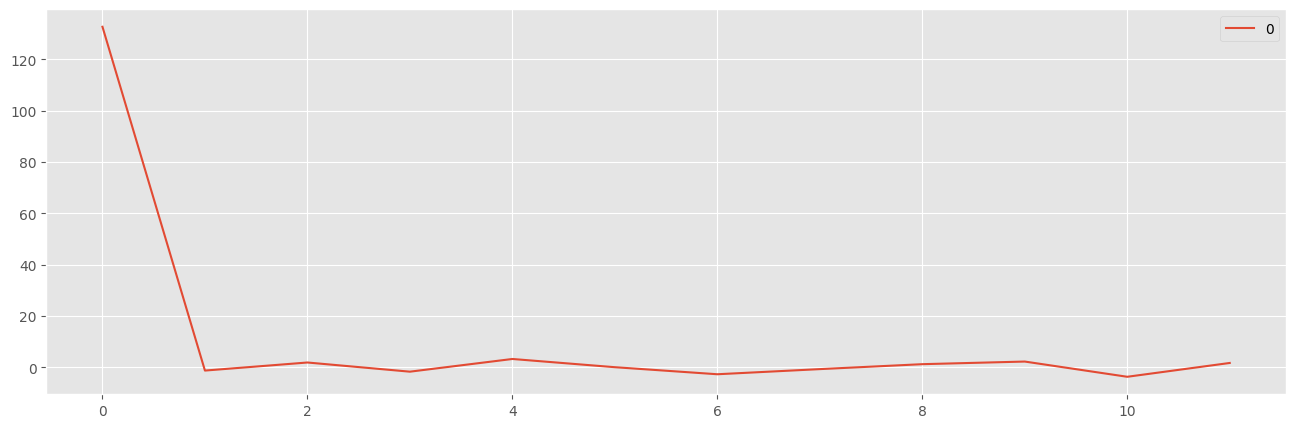

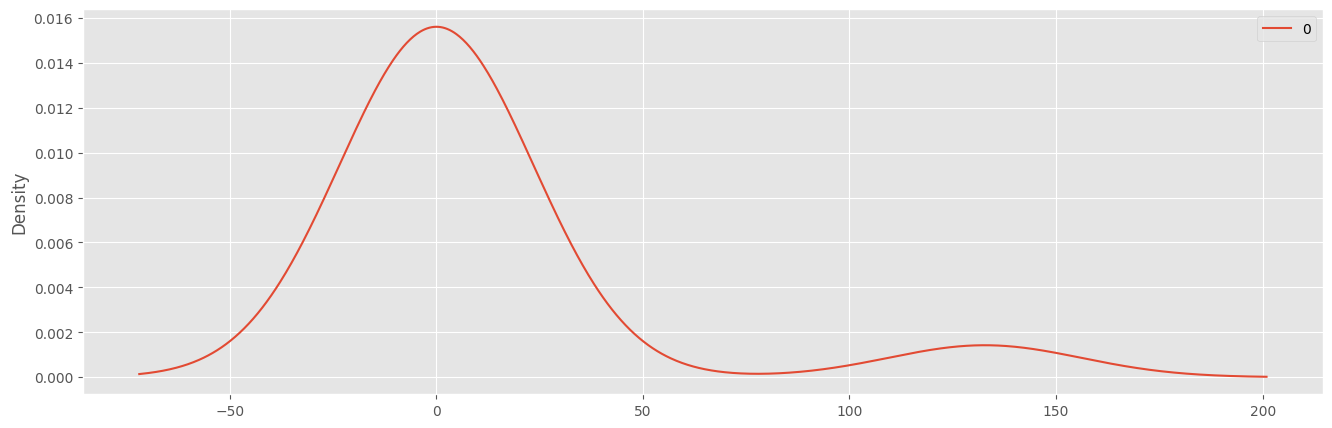

                0
count   12.000000
mean    11.101323
std     38.363697
min     -3.668906
25%     -1.356471
50%      0.651822
75%      1.987594
max    132.736505


In [20]:
# line plot of residual errors
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

# kernel density plot of residual errors
residuals.plot(kind='kde', figsize = (16,5))
plt.show()
print(residuals.describe())

ValueError: ignored

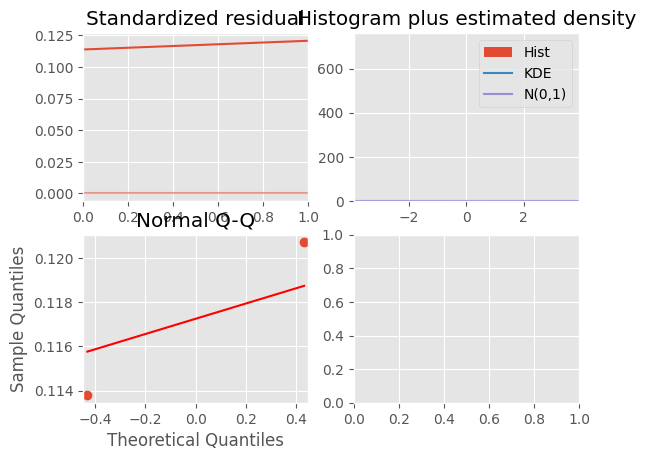

In [33]:
# Obtener los diagnósticos del modelo ARIMA ajustado por auto_arima
arima_diagnostics = modelo_auto.plot_diagnostics(lags=9)  # Ajusta el número de lags según tus necesidades
plt.show()


 ARIMA(0,1,0)(0,1,0)[9] intercept


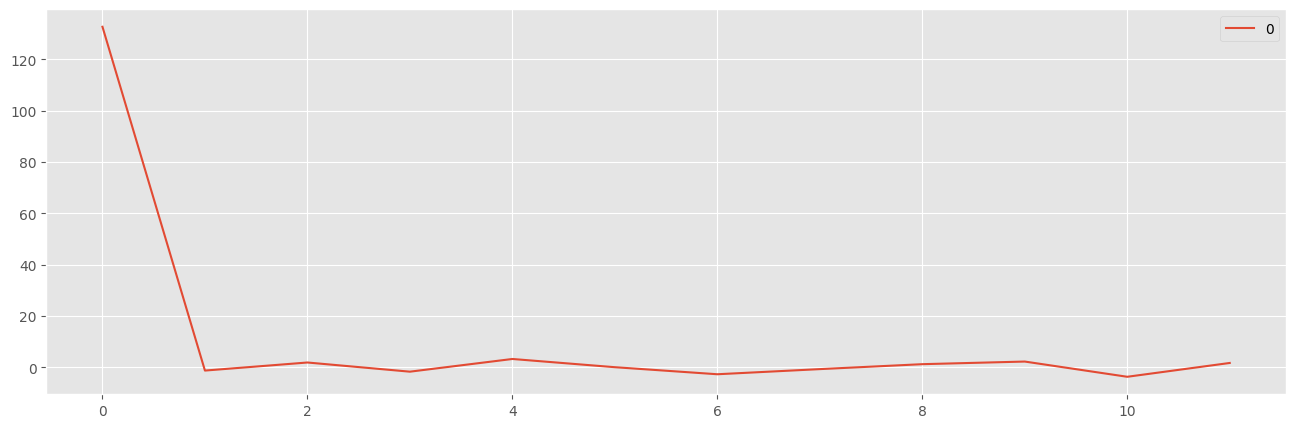

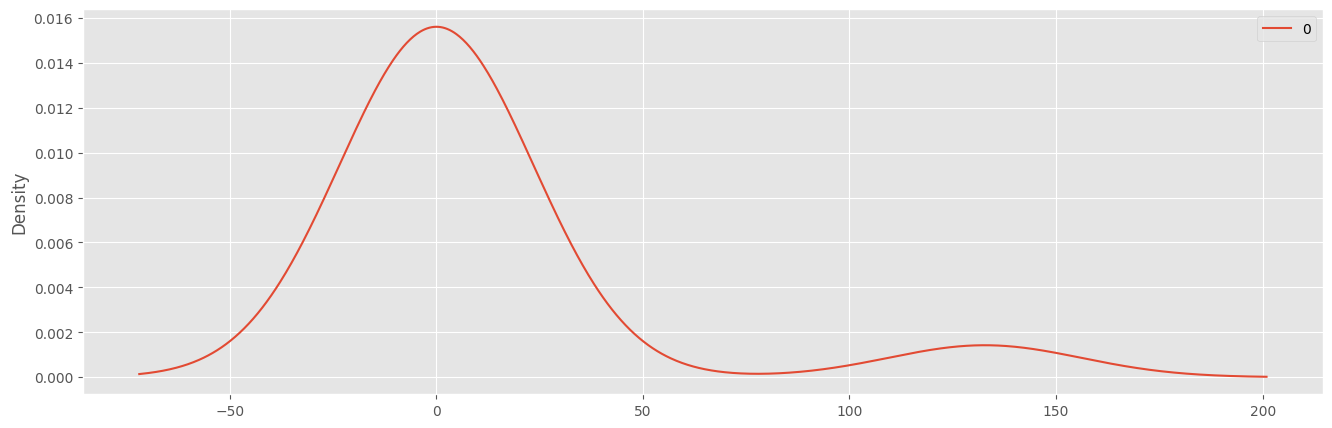

                0
count   12.000000
mean    11.101323
std     38.363697
min     -3.668906
25%     -1.356471
50%      0.651822
75%      1.987594
max    132.736505


ValueError: ignored

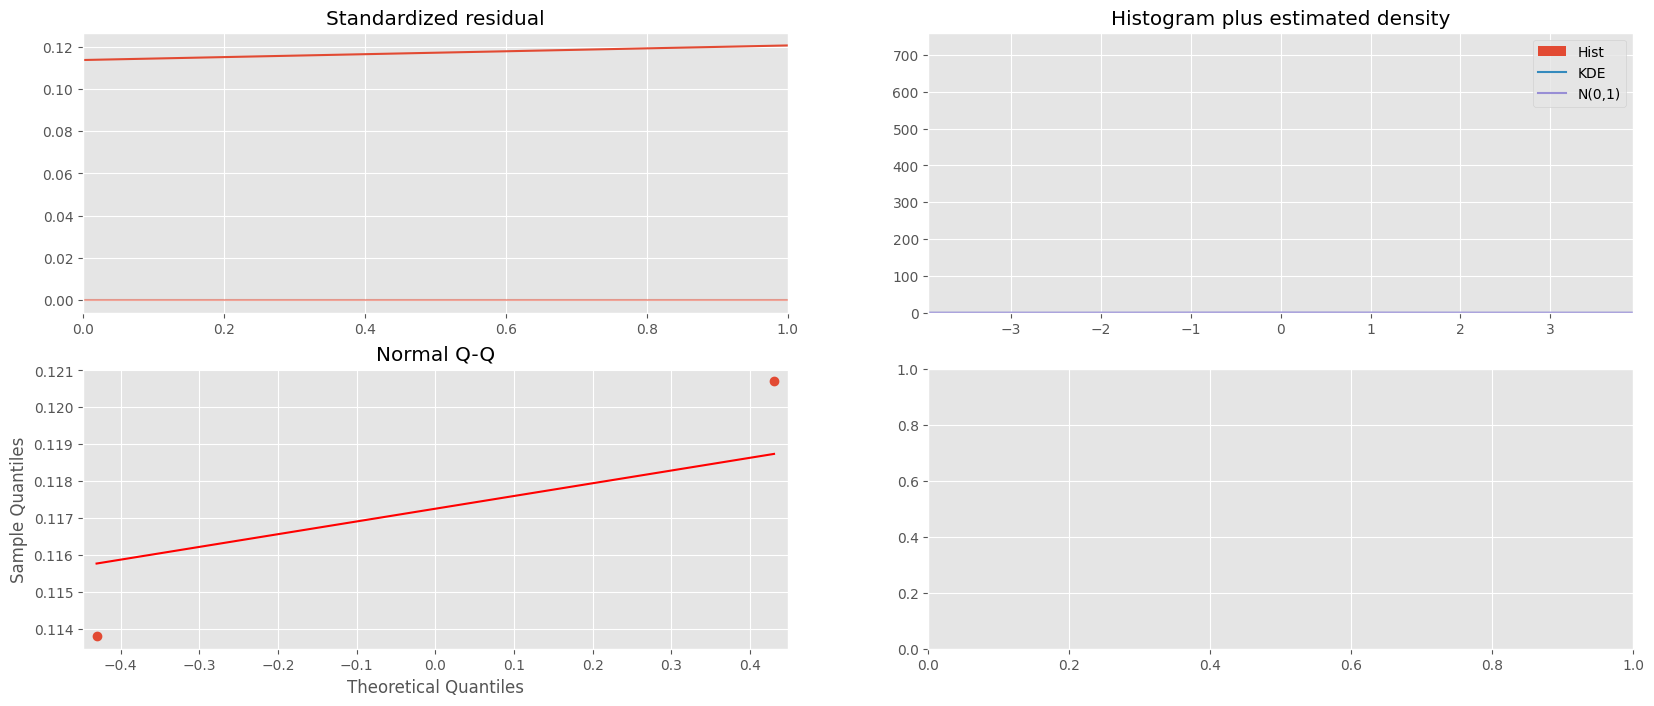

In [34]:
# 2.  Modelo : ARIMA

#train_data['Month'] = train_data['Month'].dt.to_timestamp()
train_data['Month_numeric'] = train_data['Month'].dt.year * 12 + train_data['Month'].dt.month

# Luego, utiliza 'Month_numeric' como la serie temporal en auto_arima
modelo_auto = auto_arima(train_data['Month_numeric'], start_p=0, d=1, start_q=0,
                         max_p=4, max_d=2, max_q=4, start_P=0,
                         D=1, start_Q=0, max_P=2, max_D=1,
                         max_Q=2, m=9, seasonal=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)
print(modelo_auto)

arima_model = SARIMAX(train_data["TIEMPO_TOTAL_FINAL"], order = (0,1,0), seasonal_order = (0,1,0,12))
arima_result = arima_model.fit()
arima_result.summary()

# line plot of residual errors
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

# kernel density plot of residual errors
residuals.plot(kind='kde', figsize = (16,5))
plt.show()
print(residuals.describe())

modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

print(modelo_auto.summary())

arima_pred = arima_result.predict(start = len(train_data), end = len(df6)-1, typ="levels").rename("ARIMA Predictions")
test_data['ARIMA_Predictions'] = arima_pred

# Grafica test_data
a=test_data[["TIEMPO_TOTAL_FINAL","ARIMA_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_dark",
              title="Predicción con Modelo ARIMA")
fig.show()

# evalaucion metricas de Modelo : Arima
evaluacion_metrica(test_data["TIEMPO_TOTAL_FINAL"],test_data["ARIMA_Predictions"])

In [ ]:
# 2.  Modelo : ARIMA

import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.express as px

#train_data['Month'] = train_data['Month'].dt.to_timestamp()
train_data['Month_numeric'] = train_data['Month'].dt.year * 12 + train_data['Month'].dt.month

# Luego, utiliza 'Month_numeric' como la serie temporal en auto_arima
modelo_auto = auto_arima(train_data['Month_numeric'], start_p=0, d=1, start_q=0,
                         max_p=4, max_d=2, max_q=4, start_P=0,
                         D=1, start_Q=0, max_P=2, max_D=1,
                         max_Q=2, m=9, seasonal=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)
print(modelo_auto)

arima_model = SARIMAX(train_data["TIEMPO_TOTAL_FINAL"], order = (0,1,0), seasonal_order = (0,1,0,12))
arima_result = arima_model.fit()
arima_result.summary()

# line plot of residual errors
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

# kernel density plot of residual errors
residuals.plot(kind='kde', figsize = (16,5))
plt.show()
print(residuals.describe())

#modelo_auto.plot_diagnostics(figsize=(20,8))
#plt.show()

# Ajustar auto_arima y obtener el mejor modelo
modelo_auto.fit(train_data['Month_numeric'])
best_order = modelo_auto.order
best_seasonal_order = modelo_auto.seasonal_order

# Crear y ajustar manualmente el mejor modelo
best_model = SARIMAX(train_data["TIEMPO_TOTAL_FINAL"], order=best_order, seasonal_order=best_seasonal_order)
best_result = best_model.fit()

# Mostrar los diagnósticos
best_result.plot_diagnostics(figsize=(20, 8))
plt.show()

print(modelo_auto.summary())

arima_pred = arima_result.predict(start = len(train_data), end = len(df6)-1, typ="levels").rename("ARIMA Predictions")
test_data['ARIMA_Predictions'] = arima_pred

# Grafica test_data
a=test_data[["TIEMPO_TOTAL_FINAL","ARIMA_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_dark",
              title="Predicción con Modelo ARIMA")
fig.show()

# evalaucion metricas de Modelo : Arima
evaluacion_metrica(test_data["TIEMPO_TOTAL_FINAL"],test_data["ARIMA_Predictions"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 3s 16ms/step - loss: 0.3369
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 0.1469
Epoch 3/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0716
Epoch 4/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0761
Epoch 5/10
11/11 [==============================] - 0s 29ms/step - loss: 0.0709
Epoch 6/10

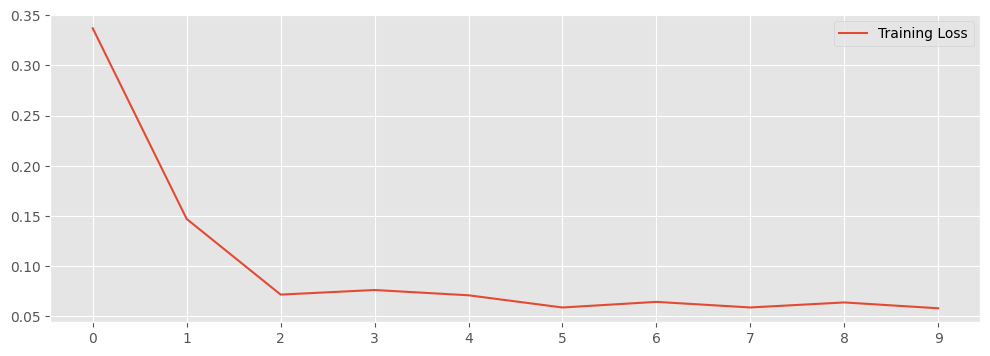

1/1 [==============================] - 0s 33ms/step


Evaluation metric results:-
MSE is : 42.779276156479
MAE is : 6.215969210720715
RMSE is : 6.540586835787673
MAPE is : 6.609435367074856
R2 is : -0.09679542675720532



In [64]:
# 3. Modelo : LSTM_Predictions

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# train_data = train_data_ori

# Seleccionar solo columnas numéricas
numeric_columns = train_data.select_dtypes(include=['float64']).columns

# Aplicar MinMaxScaler solo a las columnas numéricas
scaler = MinMaxScaler()
scaler.fit(train_data[numeric_columns])

# Transformar el conjunto de entrenamiento y prueba solo en las columnas numéricas
scaled_train_data = scaler.transform(train_data[numeric_columns])
scaled_test_data = scaler.transform(test_data[numeric_columns])

# Definir parámetros
n_input = 5
n_features = 1

# Antes de crear el modelo LSTM, debemos crear un objeto Generador de series temporales.

# Crear el generador
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

# Crear el modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
lstm_model.summary()

# Entrenar el modelo utilizando el generador
lstm_model.fit(generator, epochs=10)  # Ajusta el número de épocas según sea necesario

# Obtener el historial de entrenamiento
history = lstm_model.history

# Verificar si hay algún error durante el entrenamiento
if history is None:
    print("Error: El objeto History no se ha devuelto. Revisa tu código.")
else:
    # Acceder a las métricas de entrenamiento
    losses_lstm = history.history['loss']
    plt.figure(figsize=(12, 4))
    plt.xticks(np.arange(0, 21, 1))
    plt.plot(range(len(losses_lstm)), losses_lstm, label='Training Loss')
    plt.legend()
    plt.show()


lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions
test_data['LSTM_Predictions'] = lstm_predictions

test_data = test_data.drop(columns=['Month1'])

ai=test_data[["TIEMPO_TOTAL_FINAL","LSTM_Predictions"]]
fig = px.line(ai, x=test_data.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

# evalaucion metricas de Modelo : LSTM
evaluacion_metrica(test_data["TIEMPO_TOTAL_FINAL"],test_data["LSTM_Predictions"])

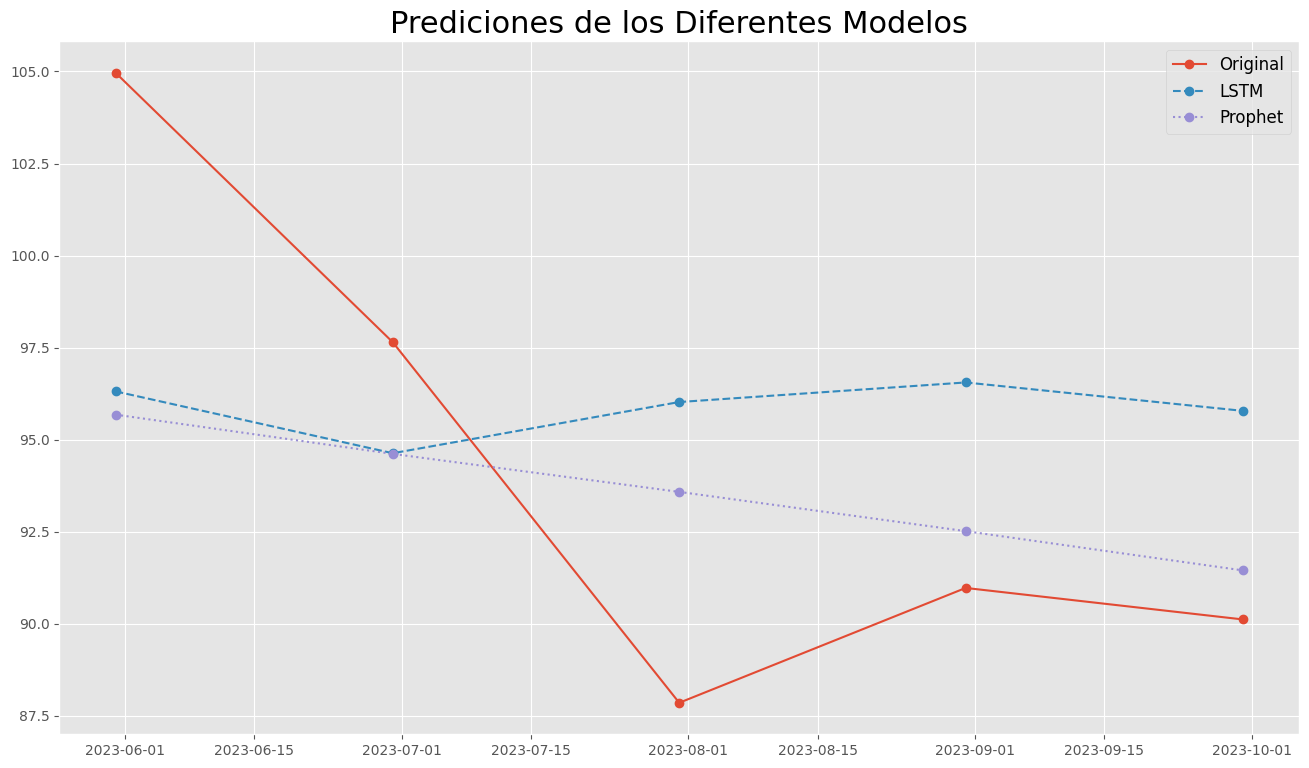

In [65]:
# mostrar todas los modelos

plt.figure(figsize=(16,9))
plt.plot_date(test_data["Month"], test_data["TIEMPO_TOTAL_FINAL"],label="Original", linestyle="-")
#plt.plot_date(test_data["Month"], test_data["ARIMA_Predictions"], label="Arima",linestyle="-.")
plt.plot_date(test_data["Month"], test_data["LSTM_Predictions"],label="LSTM", linestyle="--")
plt.plot_date(test_data["Month"], test_data["Prophet_Predictions"], label="Prophet",linestyle=":")
plt.legend(fontsize=12)
plt.title("Prediciones de los Diferentes Modelos", fontsize=22)
plt.show();

In [66]:
test_data

,index,Month,TIEMPO_TOTAL_FINAL,Prophet_Predictions,LSTM_Predictions
16,16,2023-05,104.964626,95.680576,96.312116
17,17,2023-06,97.646652,94.614332,94.632453
18,18,2023-07,87.855113,93.582482,96.022866
19,19,2023-08,90.973791,92.516238,96.554446
20,20,2023-09,90.118430,91.449993,95.783160


In [39]:
df

,FECHA_LLEGADA,TIEMPO_TOTAL_FINAL,CENTRO_ATENCION,CLASIFICACION_TRIAGE,PACIENTE_EDAD,PACIENTE_#_DOCUMENTO,EDAD_RANGO,NOMBRE_ENTIDAD,SEXO,DIA_SEMANA,ANUAL,TIEMPO_TOTAL_FINAL_change
Month,,,,,,,,,,,,
2023-02,2023-02-24 05:31:45,16.00,VB,3,69,4450531,ADULTO MAYOR,EPSC34,MASCULINO,4,2023,0.066667
2023-08,2023-08-07 23:16:10,16.00,VC,3,50,5267156,ADULTO,EPSC34,FEMENINO,0,2023,0.000000
2023-09,2023-09-13 01:56:53,17.00,UC,3,79,5667630,ADULTO MAYOR,EPSC34,MASCULINO,2,2023,0.062500
2023-06,2023-06-29 02:42:38,18.00,UC,3,72,3014617,ADULTO MAYOR,EPSS05,MASCULINO,3,2023,0.058824
2023-01,2023-01-20 13:25:45,20.00,UC,3,48,52277907,ADULTO,EPSC34,FEMENINO,4,2023,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07,2022-07-21 10:27:00,994.45,ME - HOSPITAL MEISSEN,3 - TRIAGE III - NO DEBE SUPERAR LAS 3 HORAS,58 ANO(S),39532594,ADULTEZ,CAPITAL SALUD EPS-S S.A.S,FEMENINO,3,2022,0.000251
2022-12,2022-12-15 14:50:00,994.80,UC - CENTRO DE SALUD SANTA LIBRADA I,3 - TRIAGE III - NO DEBE SUPERAR LAS 3 HORAS,54 ANO(S),39723106,ADULTEZ,CAPITAL SALUD EPS-S S.A.S,FEMENINO,3,2022,0.000352
2023-04,2023-04-10 18:02:25,994.92,ME,3,4,1033822858,PRIMERA INFANCIA,EPSC34,MASCULINO,0,2023,0.000121


In [68]:
test_data

,index,Month,TIEMPO_TOTAL_FINAL,Prophet_Predictions,LSTM_Predictions,TIEMPO_TOTAL_FINAL_change
17,17,2023-06,97.646652,94.614332,94.632453,-0.069718
18,18,2023-07,87.855113,93.582482,96.022866,-0.100275
19,19,2023-08,90.973791,92.516238,96.554446,0.035498
20,20,2023-09,90.118430,91.449993,95.783160,-0.009402


In [70]:
# 4. Modelo :  Random Forest
df5 = test_data
#df5 = test_data

df5['TIEMPO_TOTAL_FINAL_change']= df5['TIEMPO_TOTAL_FINAL'].pct_change()
df5.dropna(inplace=True)
df5.head()
df5['TIEMPO_TOTAL_FINAL_change'].describe()


count    2.000000
mean     0.013048
std      0.031749
min     -0.009402
25%      0.001823
50%      0.013048
75%      0.024273
max      0.035498
Name: TIEMPO_TOTAL_FINAL_change, dtype: float64

In [71]:
# Convertir la columna 'Month' a un formato serializable (cadena)
df5['Month'] = df5['Month'].dt.strftime('%Y-%m')  # Ajusta el formato según tus necesidades

# Crear el gráfico
fig = px.line(df5, x="Month", y="TIEMPO_TOTAL_FINAL_change", template="plotly_dark",
              title="Porcentaje de Cambio")

# Mostrar el gráfico
fig.show()

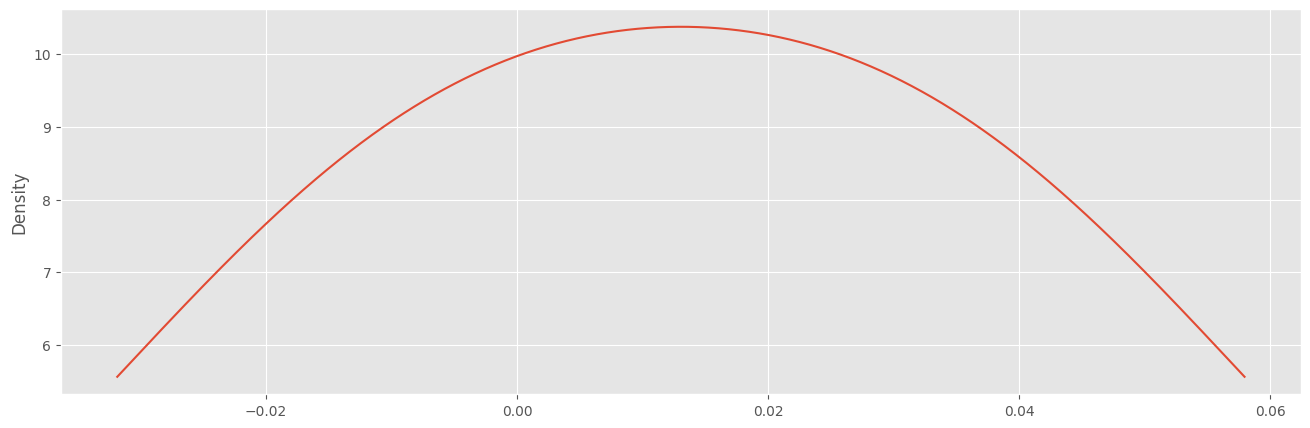

In [74]:
df5['TIEMPO_TOTAL_FINAL_change'].plot(kind='kde',figsize = (16,5));

# Seasonality variables

df5['Month'] = pd.to_datetime(df5['Month'], format='%Y-%m')

# Ahora puedes continuar con las otras conversiones
df5['Year'] = df5['Month'].apply(lambda x: x.year)
df5['Mes'] = df5['Month'].apply(lambda x: x.month)


In [ ]:

# Adding a year of lagged data
df5['L1'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(1)
df5['L2'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(2)
df5['L3'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(3)
df5['L4'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(4)
df5['L5'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(5)
df5['L6'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(6)

df5.head(13)

# df5 = df5.dropna()
df5= df5.set_index("Month")
df5.head()

In [78]:
df5

,index,TIEMPO_TOTAL_FINAL,Prophet_Predictions,LSTM_Predictions,TIEMPO_TOTAL_FINAL_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7
Month,,,,,,,,,,,,,,
2023-08-01,19,90.973791,92.516238,96.554446,0.035498,2023,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01,20,90.118430,91.449993,95.783160,-0.009402,2023,9,0.035498,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Modelación
furn = df5
# split into lagged variables (features) and original time series data (target)
X2= df5.iloc[:,2:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y2 = furn.iloc[:,1]  # slice all rows and last column, essentially separating out 't' column
X2

# Target Train-Test split
from pandas import read_csv

Y2 = y2
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observations for Target: %d' % (len(Y2)))
print('Training Observations for Target: %d' % (len(train_target)))
print('Testing Observations for Target: %d' % (len(test_target)))

Observations for Target: 2
Training Observations for Target: 1
Testing Observations for Target: 1


In [80]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=500)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones
fcst = rfr.predict(test_feature)

b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

fig = px.line(b, x=b.index, y=b.columns,template = "plotly_dark",
              title="Predicción con Modelo Random Forest")
fig.show()

# Evaluacion metricas del modelo : Random Forest
evaluacion_metrica(test_target,fcst)

NameError: ignored

In [67]:
# 4. Modelo :  Random Forest
df5 = test_data
#df5 = test_data

df5['TIEMPO_TOTAL_FINAL_change']= df5['TIEMPO_TOTAL_FINAL'].pct_change()
df5.dropna(inplace=True)
df5.head()
df5['TIEMPO_TOTAL_FINAL_change'].describe()

fig = px.line(df5, x="Month", y="TIEMPO_TOTAL_FINAL_change",template = "plotly_dark",
              title="Porcentaje de Cambio")
fig.show()

df5['TIEMPO_TOTAL_FINAL_change'].plot(kind='kde',figsize = (16,5));

# Seasonality variables
df5['Month'] = df5['Month'].dt.to_timestamp()

# Ahora puedes continuar con las otras conversiones
df5['Year'] = df5['Month'].apply(lambda x: x.year)
df5['Mes'] = df5['Month'].apply(lambda x: x.month)

# Adding a year of lagged data
df5['L1'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(1)
df5['L2'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(2)
df5['L3'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(3)
df5['L4'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(4)
df5['L5'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(5)
df5['L6'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(6)
df5['L7'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(7)
df5['L8'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(8)
df5['L9'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(9)
df5['L10'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(10)
df5['L11'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(11)
df5['L12'] = df5["TIEMPO_TOTAL_FINAL_change"].shift(12)

df5.head(13)

# df5 = df5.dropna()
df5= df5.set_index("Month")
df5.head()


# Modelación
furn = df5
# split into lagged variables (features) and original time series data (target)
X2= df5.iloc[:,2:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y2 = furn.iloc[:,1]  # slice all rows and last column, essentially separating out 't' column
X2

# Target Train-Test split
from pandas import read_csv

Y2 = y2
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observations for Target: %d' % (len(Y2)))
print('Training Observations for Target: %d' % (len(train_target)))
print('Testing Observations for Target: %d' % (len(test_target)))


# Features Train-Test split

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observations for feature: %d' % (len(X2)))
print('Training Observations for feature: %d' % (len(train_feature)))
print('Testing Observations for feature: %d' % (len(test_feature)))

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=500)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones
fcst = rfr.predict(test_feature)

b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

fig = px.line(b, x=b.index, y=b.columns,template = "plotly_dark",
              title="Predicción con Modelo Random Forest")
fig.show()

# Evaluacion metricas del modelo : Random Forest
evaluacion_metrica(test_target,fcst)

TypeError: ignored

In [ ]:
#  5. Modelo :  forecasting series temporales con Python y Scikit-learn

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

Fechas train : 2022-01-01 00:00:00 --- 2022-09-01 00:00:00  (n=9)
Fechas test  : 2022-10-01 00:00:00 --- 2023-09-01 00:00:00  (n=12)


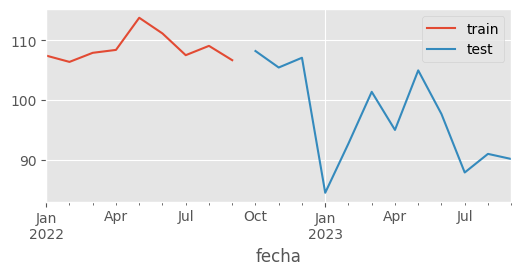

In [83]:
# 5. Modelo : Multiple output forecasting

# Resetear el índice antes de la conversión
df6 = df6.reset_index(drop=True)

# Convierte 'Month' a cadena y luego a formato Timestamp
df6['Month'] = pd.to_datetime(df6['Month'].astype(str), format='%Y-%m')

# Ahora puedes continuar con las otras conversiones
datos = df6
datos['fecha'] = pd.to_datetime(datos['Month'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos = datos.rename(columns={'TIEMPO_TOTAL_FINAL': 'y'})

# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

# Separación datos train-test
# ==============================================================================
steps = 12
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

In [84]:
# 6. Modelo : Forecasting autorregresivo recursivo

# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

NameError: ignored

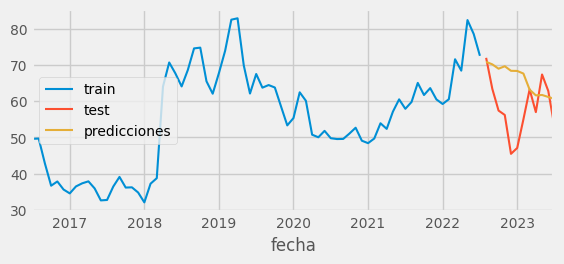

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

# Resultados Grid Search
# ==============================================================================
resultados_grid

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 71.00953593067813



,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",71.009536,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",71.434458,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",71.552524,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",71.584441,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",71.617320,5,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",71.752363,3,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",198.464857,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",201.324686,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",203.142210,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",204.810631,10,100
